<a href="https://colab.research.google.com/github/drkaushiksarkar/industrial_safety_chatbot/blob/main/nlp%2Bcapstone%2BDL%2Bmodel%2Bfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install --upgrade tensorflow

In [ ]:
import os
import pandas as pd
import numpy as np


import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers import SpatialDropout1D
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kaushik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
cd bot

/Users/kaushik/Desktop/bot


In [ ]:
def clean_text(text):
	REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
	BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
	STOPWORDS = set(stopwords.words('english'))
	text = text.lower() # lowercase text
	text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
	text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
	text = text.replace('x', '')
	text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
	return text
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
	contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
	return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
	def replace(match):
		return contractions[match.group(0)]
	return contractions_re.sub(replace, text)

In [ ]:
df= pd.read_csv("industrial_safety_and_health_database_with_accidents_description.csv", encoding="latin-1")
df = df.drop('Unnamed: 0', axis = 1)
df = df.drop_duplicates(keep='first')
df.rename(columns={'Data':'Date', 'Countries':'Country', 'Genre':'Gender', 'Employee or Third Party':'Employee', 'Industry Sector': 'Industry', 'Critical Risk': 'Risk'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].apply(lambda x : x.month_name())
df['Weekday'] = df['Date'].apply(lambda x : x.day_name())
df['Employee'] = df['Employee'].str.replace(' ', '_')
df['Risk'] = df['Risk'].str.replace('\n', '').str.replace(' ', '_')
df = df.reset_index(drop=True)


# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Description'].values)
word_index = tokenizer.word_index


data = df[['Description', 'Accident Level']]
details = df.drop(['Description', 'Accident Level'], axis=1)
values = ['low-grade', 'low-grade', 'high-grade', 'high-grade', 'high-grade', 'high-grade']
conditions = [
(details['Potential Accident Level'] == 'I'),
    (details['Potential Accident Level'] == 'II'),
    (details['Potential Accident Level'] == 'III'),
    (details['Potential Accident Level'] == 'IV'),
    (details['Potential Accident Level'] == 'V'),
    (details['Potential Accident Level'] == 'VI')
    ]

values_2 = ['low-grade', 'high-grade', 'high-grade', 'high-grade', 'high-grade']
conditions_2 = [
(details['Potential Accident Level'] == 'I'),
    (details['Potential Accident Level'] == 'II'),
    (details['Potential Accident Level'] == 'III'),
    (details['Potential Accident Level'] == 'IV'),
    (details['Potential Accident Level'] == 'V')
    ]

    
data['acc_grade'] = np.select(conditions_2, values_2)
details['pot_acc_grade'] = np.select(conditions, values)
data = data.drop_duplicates(keep='first')
details = details.drop_duplicates(keep='first')

# Features and Labels
X = tokenizer.texts_to_sequences(data['Description'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
Y = data['acc_grade']


Y_details = details['pot_acc_grade']
X_details = details.drop(['Date','Potential Accident Level', 'pot_acc_grade'], axis = 1)


<ipython-input-5-54acc39f4e28>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['acc_grade'] = np.select(conditions_2, values_2)


In [ ]:
count_df = df[['Accident Level','Description']].groupby('Accident Level').aggregate({'Description':'count'}).reset_index().sort_values('Description',ascending=False)
count_df.head()

,Accident Level,Description
0,I,309
1,II,40
2,III,31
3,IV,30
4,V,8


In [ ]:
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(X_details)
X_details = encoder.transform(X_details)
with open("encoder", "wb") as f: 
    pickle.dump(encoder, f)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_details, Y_details, test_size = 0.10, random_state = 1, stratify = Y_details)

In [ ]:
# ML Model 
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.6666666666666666

In [ ]:
confusion_matrix(y_test, y_pred)

array([[23,  5],
       [ 9,  5]])

# Feature Selection

In [ ]:
results=pd.DataFrame()
results['_columns']=pd.DataFrame(X_train).columns
results['importances'] = rf_clf.feature_importances_
results.sort_values(by='importances',ascending=False,inplace=True)

results[:50]

,_columns,importances
13,13,0.054056
16,16,0.051098
33,33,0.039354
14,14,0.034929
65,65,0.033797
64,64,0.033001
61,61,0.031415
55,55,0.031040
66,66,0.030527
54,54,0.030055


In [ ]:
imp_feature_data = results[:50]

In [ ]:
feature_list = imp_feature_data["_columns"].unique().tolist()

In [ ]:
X_details = pd.DataFrame(X_details)

In [ ]:
X_details = X_details[feature_list]

In [ ]:
# save the feature list to disk
with open("feature_list", "wb") as f: 
    pickle.dump(feature_list, f)

# New Model with Selected Features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_details, Y_details, test_size = 0.20, random_state = 1, stratify = Y_details)

In [ ]:
# ML Model 
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.6867469879518072

In [ ]:
param_range = np.arange(1, 250, 2)
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = param_range, cv = 3)

In [ ]:
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

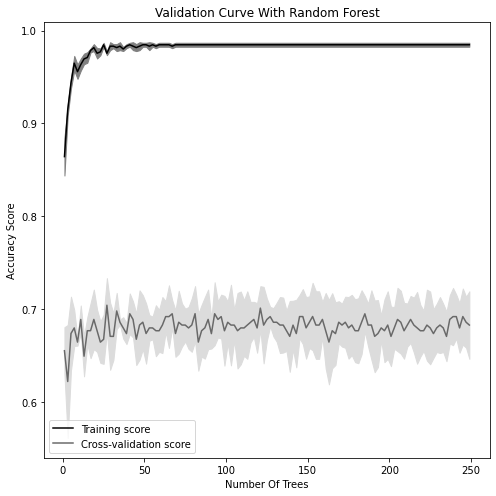

In [ ]:
plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")
 
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

# Hyperparameter tuning with GridSearchCV

In [ ]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(rf_clf, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  2.8min finished


In [ ]:
y_pred = bestF.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.7228915662650602

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

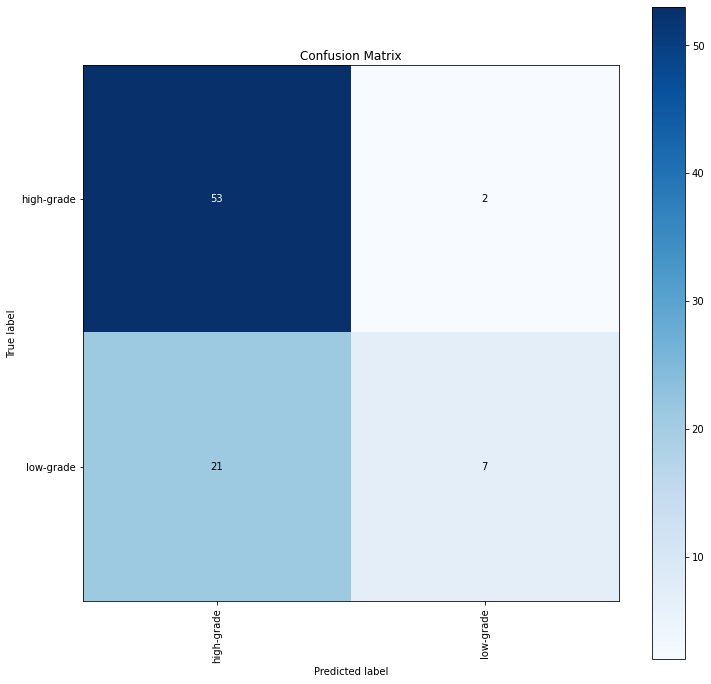

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

# Saving the best model

In [ ]:
ml_model = gridF.fit(X_details, Y_details)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  3.3min finished


In [ ]:
# save the model to disk
filename = 'finalized_ml_model.sav'
pickle.dump(ml_model, open(filename, 'wb'))

# Deep Learning Model

In [ ]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import scikitplot as skplt

import matplotlib.pyplot as plt

/Applications/Utilities/anaconda3/lib/python3.8/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = 'glove.6B.100d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(MAX_NB_WORDS, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= MAX_NB_WORDS: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
cd

/Users/kaushik


In [ ]:
os.chdir ('../kaushik/Desktop/bot')

In [ ]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too
debug = 0
if debug:
    embedding_matrix = np.random.randn(MAX_NB_WORDS,EMBEDDING_DIM)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/Applications/Utilities/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
np.shape(embedding_matrix)

(3454, 100)

In [ ]:
batch_size = 16 # how many samples to process at once
n_epochs = 50 # how many times to iterate over all samples
n_splits = 3 # Number of K-fold Splits
SEED = 10
debug = 0

In [ ]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.2
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(MAX_NB_WORDS, EMBEDDING_DIM)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.lstm = nn.LSTM(EMBEDDING_DIM, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size = 0.20, random_state = 1)

In [ ]:

le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [ ]:
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler

counts = np.bincount(train_y)
labels_weights = 1. / counts
weights = labels_weights[train_y]
sampler = WeightedRandomSampler(weights, len(weights))

In [ ]:
n_epochs = 10 
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)

# Load train and test 
x_train = torch.tensor(train_X, dtype=torch.long)
y_train = torch.tensor(train_y, dtype=torch.long)
x_cv = torch.tensor(test_X, dtype=torch.long)
y_cv = torch.tensor(test_y, dtype=torch.long)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, sampler = sampler)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<ipython-input-45-00aaa1387de4>:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/10 	 loss=9.7497 	 val_loss=4.9403  	 val_acc=0.9518  	 time=0.67s
Epoch 2/10 	 loss=2.6236 	 val_loss=3.9801  	 val_acc=0.9518  	 time=0.57s
Epoch 3/10 	 loss=0.2449 	 val_loss=8.5154  	 val_acc=0.9277  	 time=0.55s
Epoch 4/10 	 loss=0.8407 	 val_loss=9.0964  	 val_acc=0.9277  	 time=0.55s
Epoch 5/10 	 loss=0.1419 	 val_loss=7.4713  	 val_acc=0.9277  	 time=0.55s
Epoch 6/10 	 loss=0.0358 	 val_loss=7.0319  	 val_acc=0.9398  	 time=0.55s
Epoch 7/10 	 loss=0.0125 	 val_loss=7.1223  	 val_acc=0.9398  	 time=0.66s
Epoch 8/10 	 loss=0.0161 	 val_loss=9.0179  	 val_acc=0.9398  	 time=0.56s
Epoch 9/10 	 loss=0.0084 	 val_loss=9.1921  	 val_acc=0.9398  	 time=0.55s
Epoch 10/10 	 loss=0.0062 	 val_loss=9.0740  	 val_acc=0.9398  	 time=0.56s


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

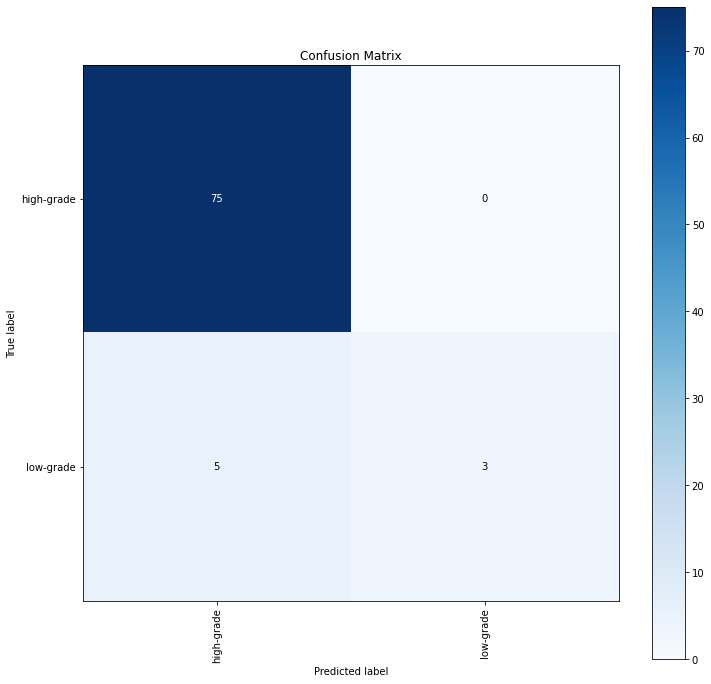

In [ ]:
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [ ]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

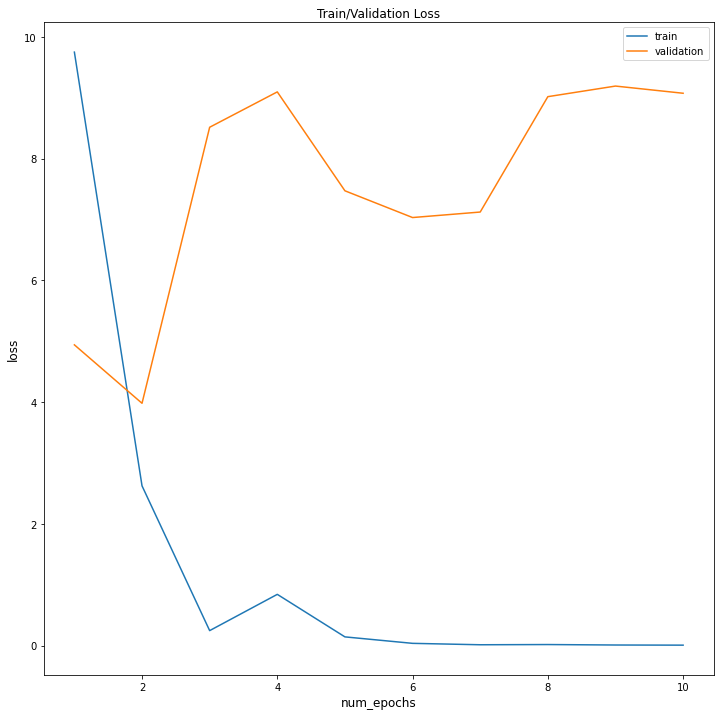

In [ ]:
plot_graph(n_epochs)

In [ ]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [2,3,5]
        num_filters = 128
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(MAX_NB_WORDS, EMBEDDING_DIM)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, EMBEDDING_DIM)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

In [ ]:
n_epochs = 10
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long)
y_train = torch.tensor(train_y, dtype=torch.long)
x_cv = torch.tensor(test_X, dtype=torch.long)
y_cv = torch.tensor(test_y, dtype=torch.long)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, sampler = sampler)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/Applications/Utilities/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
<ipython-input-50-9df221dd9e63>:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/10 	 loss=8.7541 	 val_loss=8.3208  	 val_acc=0.9518  	 time=0.43s
Epoch 2/10 	 loss=4.1884 	 val_loss=3.4429  	 val_acc=0.9277  	 time=0.31s
Epoch 3/10 	 loss=2.3074 	 val_loss=3.6551  	 val_acc=0.9398  	 time=0.29s
Epoch 4/10 	 loss=1.4246 	 val_loss=4.1685  	 val_acc=0.9398  	 time=0.30s
Epoch 5/10 	 loss=0.9495 	 val_loss=3.0864  	 val_acc=0.9398  	 time=0.30s
Epoch 6/10 	 loss=0.6657 	 val_loss=2.3963  	 val_acc=0.9398  	 time=0.30s
Epoch 7/10 	 loss=0.3327 	 val_loss=2.4047  	 val_acc=0.9398  	 time=0.29s
Epoch 8/10 	 loss=0.2666 	 val_loss=2.5119  	 val_acc=0.9398  	 time=0.30s
Epoch 9/10 	 loss=0.1852 	 val_loss=2.6107  	 val_acc=0.9398  	 time=0.30s
Epoch 10/10 	 loss=0.1615 	 val_loss=2.7104  	 val_acc=0.9398  	 time=0.30s


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

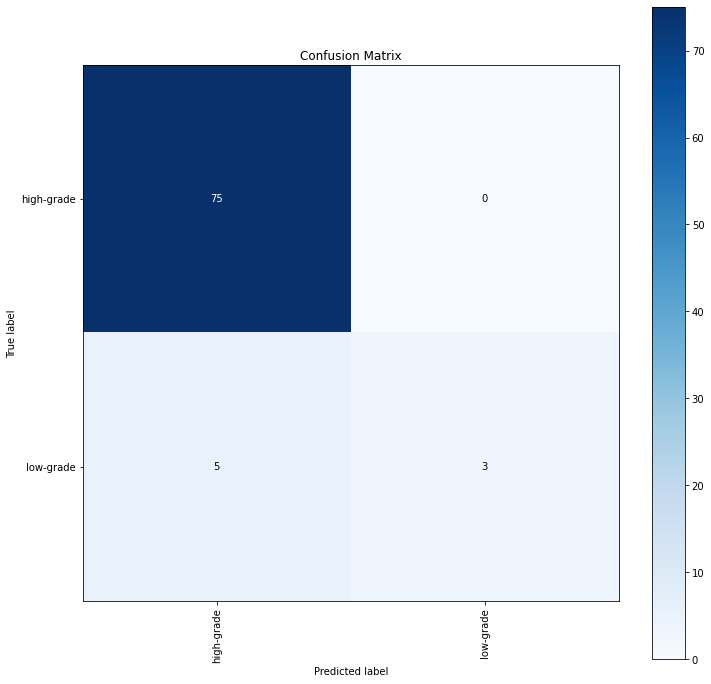

In [ ]:
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [ ]:
n_epochs = 10 
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long)
y_train = torch.tensor(train_y, dtype=torch.long)
x_cv = torch.tensor(test_X, dtype=torch.long)
y_cv = torch.tensor(test_y, dtype=torch.long)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, sampler = sampler)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<ipython-input-56-637667994dcd>:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/10 	 loss=16.1897 	 val_loss=15.4063  	 val_acc=0.0964  	 time=0.62s
Epoch 2/10 	 loss=10.6970 	 val_loss=13.2501  	 val_acc=0.1446  	 time=0.58s
Epoch 3/10 	 loss=7.0528 	 val_loss=10.3303  	 val_acc=0.4699  	 time=0.57s
Epoch 4/10 	 loss=6.1701 	 val_loss=5.0668  	 val_acc=0.9036  	 time=0.62s
Epoch 5/10 	 loss=4.2269 	 val_loss=4.4675  	 val_acc=0.8916  	 time=0.60s
Epoch 6/10 	 loss=5.5249 	 val_loss=11.2932  	 val_acc=0.3855  	 time=0.56s
Epoch 7/10 	 loss=3.6019 	 val_loss=5.0950  	 val_acc=0.8554  	 time=0.55s
Epoch 8/10 	 loss=2.6928 	 val_loss=3.4086  	 val_acc=0.8916  	 time=0.58s
Epoch 9/10 	 loss=1.6309 	 val_loss=3.2146  	 val_acc=0.8916  	 time=0.58s
Epoch 10/10 	 loss=1.1580 	 val_loss=4.7980  	 val_acc=0.9036  	 time=0.54s


In [ ]:
torch.save(model, '..\bot')

In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open("le", "wb") as f: 
    pickle.dump(le, f)

In [ ]:
os.chdir("../kaushik/Desktop/bot")

In [ ]:
PATH = 'bilstm.h5'
torch.save(model.state_dict(), PATH)

In [ ]:
with open("embedding_matrix", "wb") as f: 
    pickle.dump(embedding_matrix, f)